In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))
print(sys.path[-1])

/Users/hawkins/code/hBN_PL/src


In [2]:
#import modules
import hbn_pl.io as io
import numpy as np
import hbn_pl.preprocess as preprocess
import hbn_pl.plot as plot
import hbn_pl.peaks2 as peaks2
import hbn_pl.classification2 as classification
import csv

Performing background subtraction...
Successfully subtracted background.


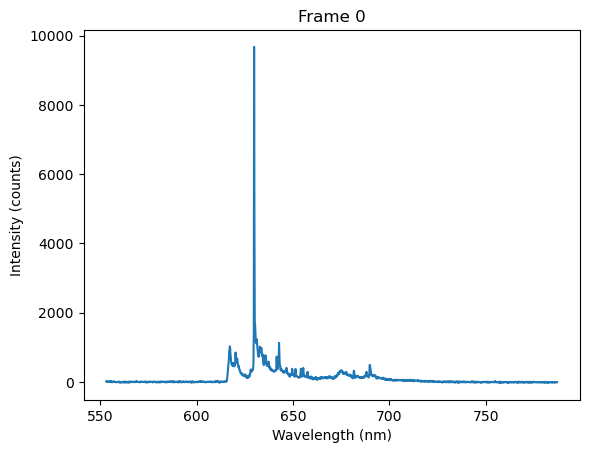

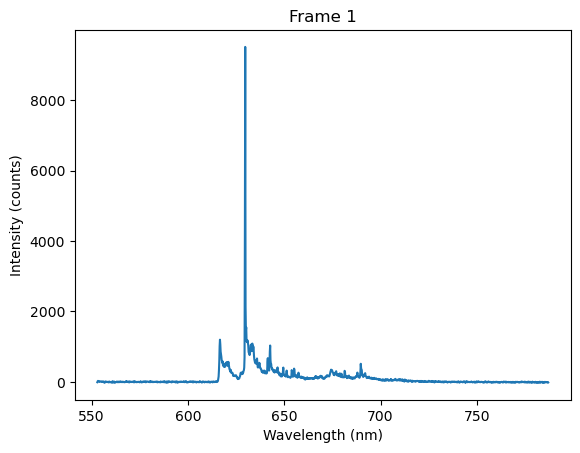

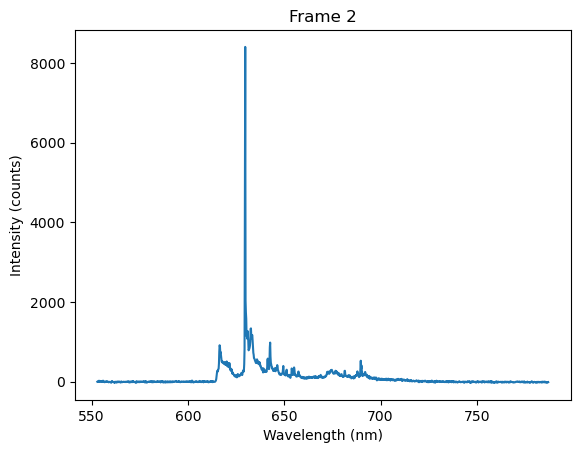

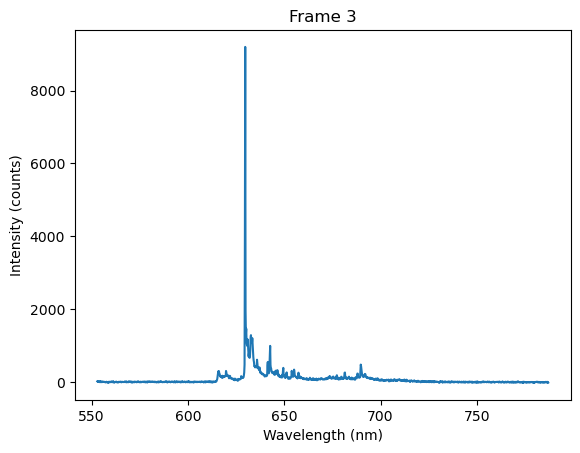

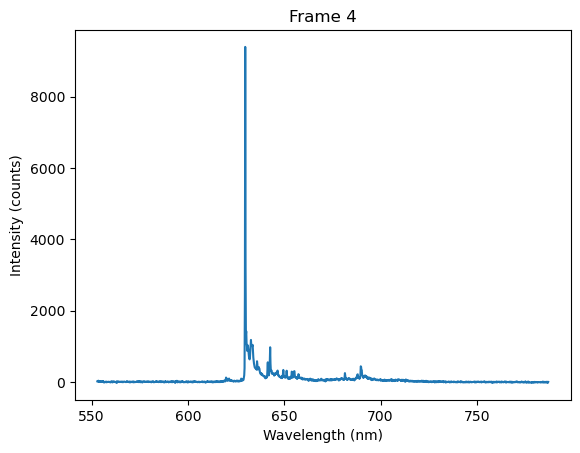

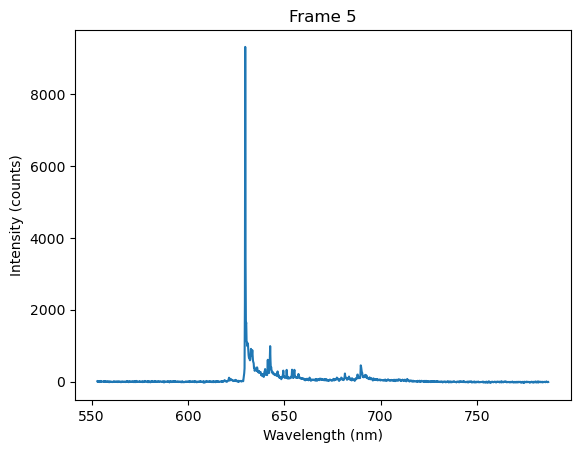

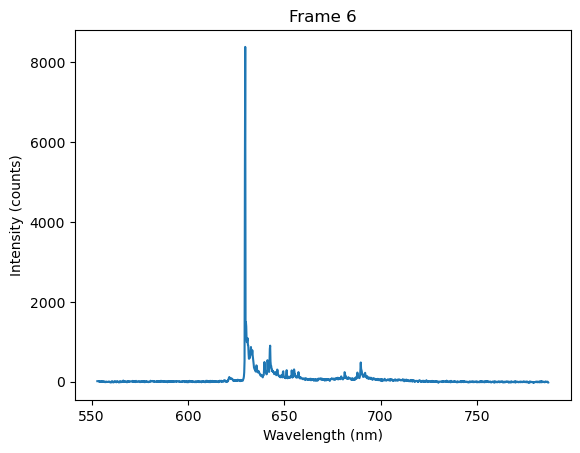

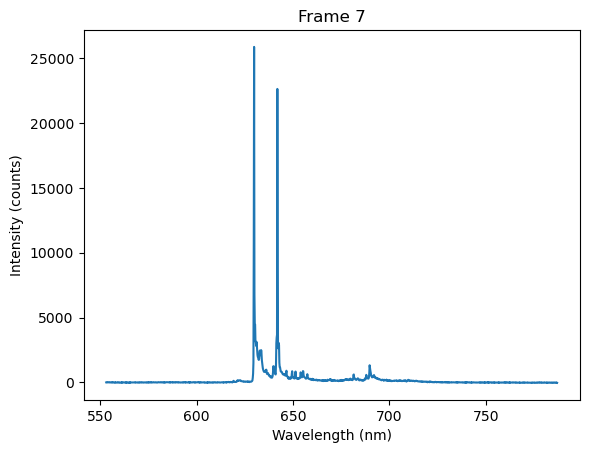

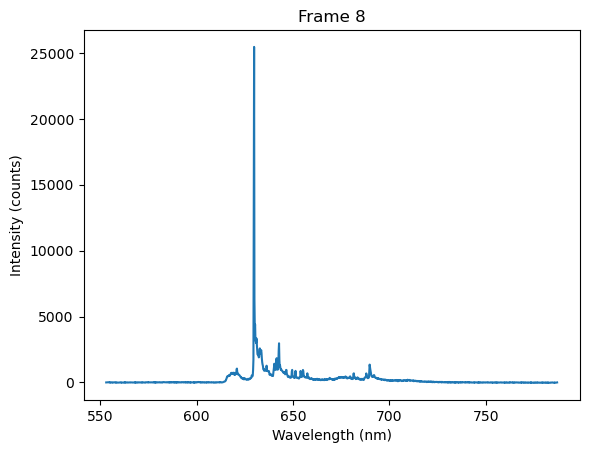

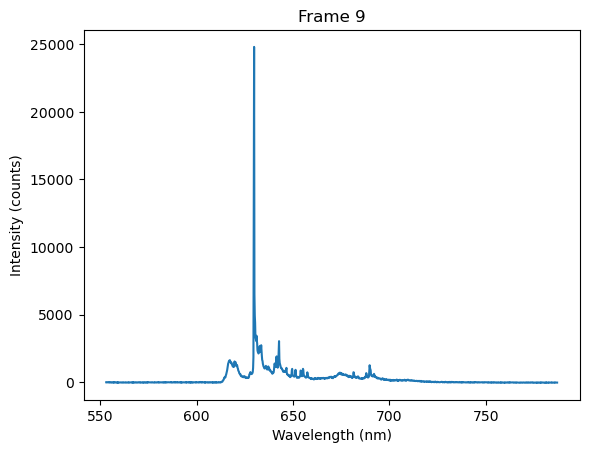

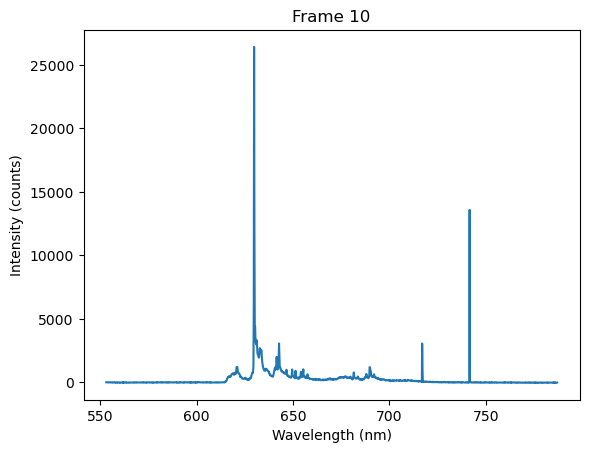

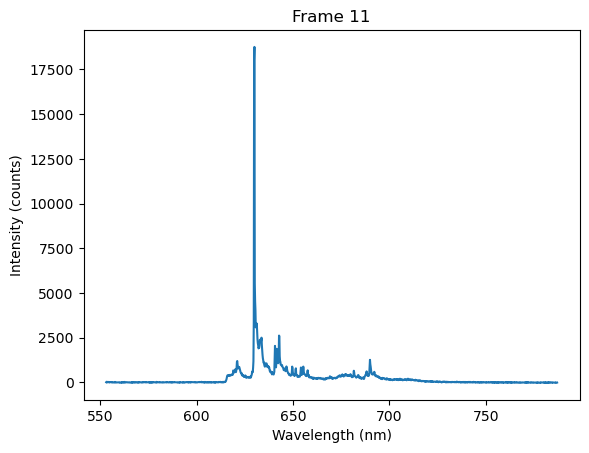

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [19]:
# load test emitter data
DATA_DIR = Path("/Users/hawkins/code/hBN_PL/data/All data")
#FILE_NAME = '2025-11-20 18_51_06 sample3_DCMd2_200uw_emitter14 2231.spe' 
#FILE_NAME = '2025-11-17 17_34_30 sample5_DCMd2_200uw_emitter11 2189.spe' # good example, lots of cosmic rays removal
FILE_NAME = '2025-11-17 17_59_53 sample5_DCMd2_200uw_emitter17 2195.spe'
spe_path = DATA_DIR / FILE_NAME
wavelength, frames = io.load_spe(spe_path)
frames = frames[0:15]

# pre-process and plot for visual check
frames = preprocess.background_subtract(frames, bg_slice=(1, 50))
plot.plot_frames(wavelength, frames)

Detecting cosmic ray frames...
Detected 2 cosmic ray frames: [7, 10]
Cosmic ray wavelengths: {7: [641.8502401788131], 10: [741.6555044814538, 717.0189181227256]}
Cosmic ray detection complete.


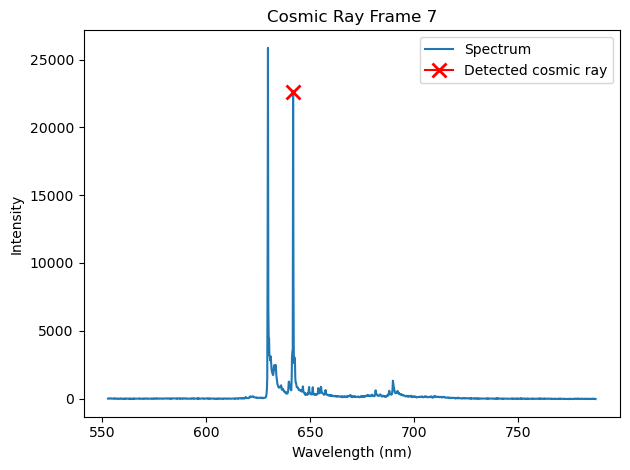

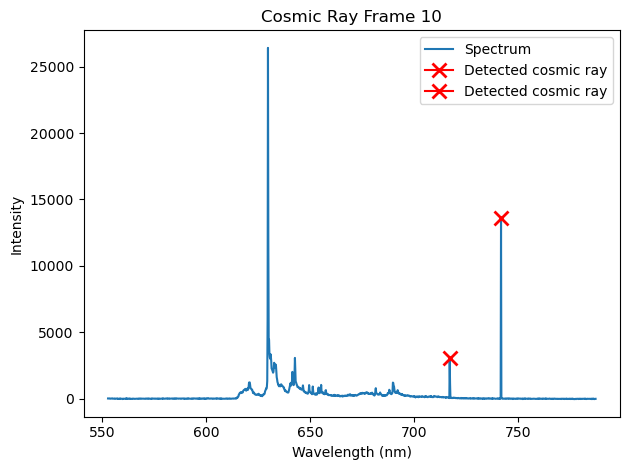

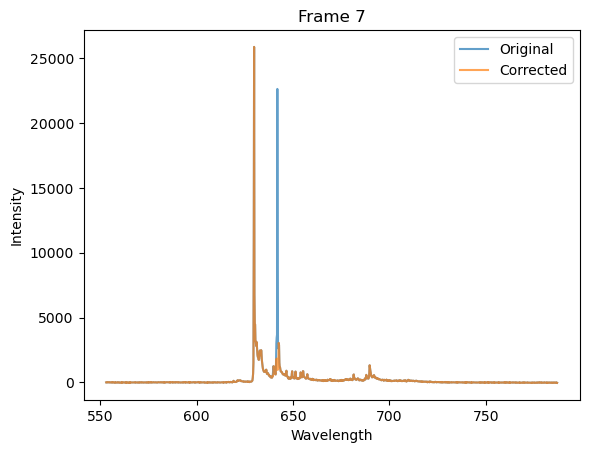

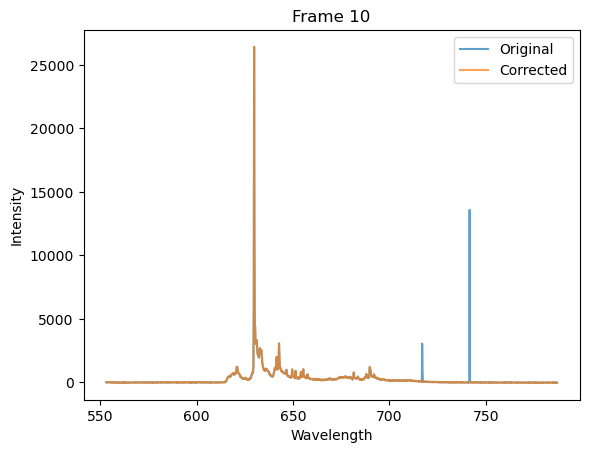

In [20]:
# Cosmic ray removal
cosmic_frames, cosmic_location = preprocess.detect_cosmic_frames(frames, wavelength,
prominence_threshold=0.05, fwhm_threshold=1.9, n_peaks=3, z_thresh=100, half_width=5, noise_width=30)
plot.plot_cosmic_frames(frames, wavelength, cosmic_location)
frames_cleaned, cosmic_figs = preprocess.remove_cosmic_rays2(frames, wavelength, cosmic_frames, cosmic_location, sigma=1.5, half_width = 5)

In [21]:
#bad frame removal

drop_fraction = 0.6
bad_frames = preprocess.detect_bad_frames_simple(frames, drop_fraction = drop_fraction)
#bad_frames = preprocess.detect_bad_frames_complex(frames, window = 5, drop_fraction = drop_fraction)
frames = preprocess.remove_frames(frames, bad_frames)

Running simple bad frame detection...
Detected bad frames due to intensity drop 0.6: [5]
Removing 1 frames: [5]
Successfully removed bad frames.


Averaging and normalising frames into a single spectrum...
Successfully averaged and normalised frames.


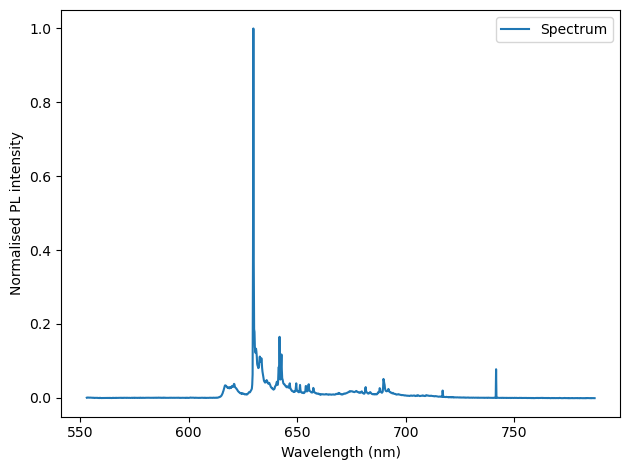

In [22]:
# average and normalise
avg, avg_norm = preprocess.average_and_normalise(frames)
plot.plot_spectrum(wavelength, avg_norm)

Detected peaks:
{'location': np.float64(629.784643988842), 'intensity': np.float64(1.0), 'fwhm': np.float64(0.17486893705176954), 'prominence': np.float64(1.000641708113715)}
{'location': np.float64(641.8502401788131), 'intensity': np.float64(0.16518867512215588), 'fwhm': np.float64(0.1748583449736998), 'prominence': np.float64(0.14310708635263059)}


/var/folders/8g/5d8vd9052js99py85nx9jxz00000gn/T/ipykernel_38063/3442268719.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


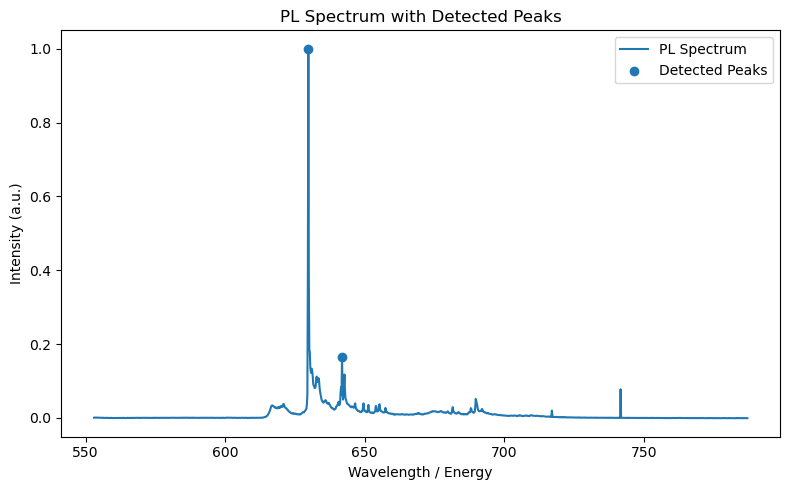

In [23]:
# peak detection
finder = peaks2.PeakFinder(wavelength, avg_norm)
finder.peak_finding(prominence=0.1)
peaks = finder.extract_peak_parameters()

print("Detected peaks:")
for p in peaks:
    print(p)

fig = finder.plot_peaks()
fig.show()

In [24]:
#classify peaks
classifier = classification.ZPLClassification(peaks, thresholds={
            "max_fwhm": 0.9,           
            "min_prominence": 0.7,   
            "location_range": [615, 660]    
        })

msg, zpl_peaks = classifier.classify()

print(msg)

Single ZPL
Peak 1: location = 629.8, prominence = 1.0


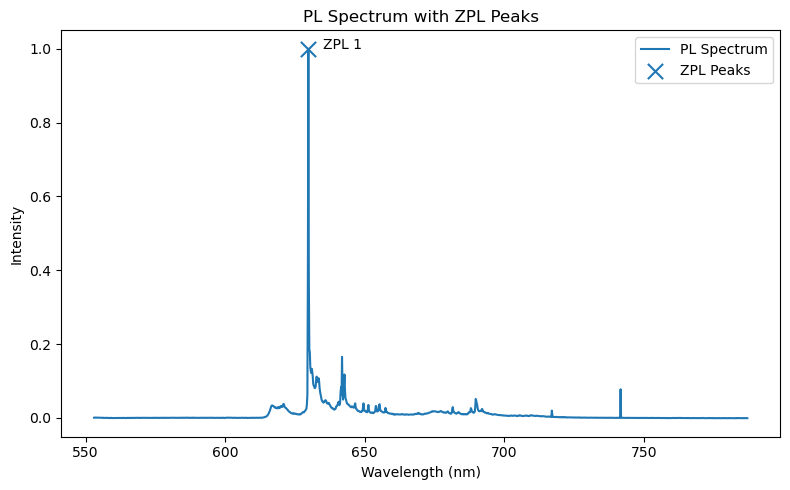

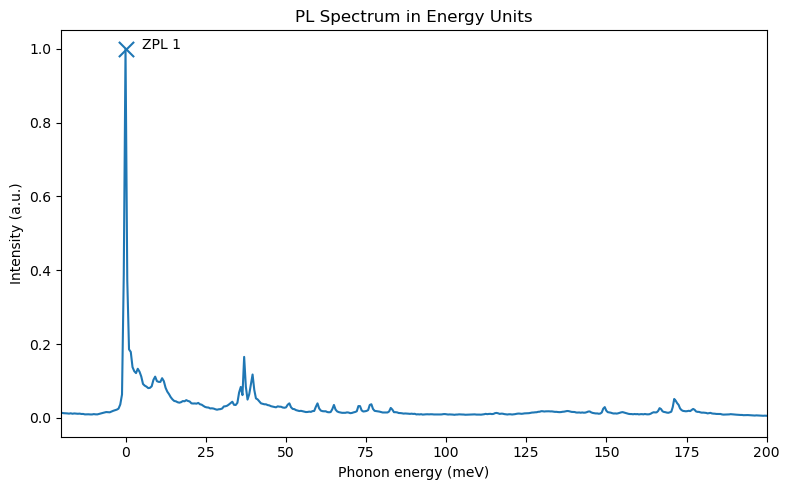

In [25]:
# plot final wavelength and energy plots
zpl_fig = finder.plot_zpl_on_spectrum(zpl_peaks)
energy_fig = finder.plot_energy(zpl_peaks)


In [26]:
# save outputs
OUTPUT_DIR = Path("/Users/hawkins/code/hBN_PL/output") # Main directory of all outputs
io.output(peaks, 
               msg, 
               OUTPUT_DIR, 
               FILE_NAME, 
               wavelength, 
               frames, 
               plot, 
               finder=finder,
               zpl_peaks = zpl_peaks,
               bad_frames=bad_frames,
               drop_fraction=drop_fraction,
               cosmic_frames=cosmic_frames,
               frames_cleaned=frames_cleaned,
               cosmic_figs = cosmic_figs
               )

Averaging and normalising frames into a single spectrum...
Successfully averaged and normalised frames.
Peakfinder outputs for emitter '2025-11-17 17_59_53 sample5_DCMd2_200uw_emitter17 2195.spe' saved in:
/Users/hawkins/code/hBN_PL/output/2025-11-17 17_59_53 sample5_DCMd2_200uw_emitter17 2195. 

Created emitter output directory: /Users/hawkins/code/hBN_PL/output/2025-11-17 17_59_53 sample5_DCMd2_200uw_emitter17 2195
Saved CSV file in emitter output directory
Saved original frame plots (11 frames) in: emitter output directory/original_frames
Saved 2 cosmic ray plots in: output directory/cosmic_ray_removal
Saved averaged and normalized spectrum plot in: output directory/normalised_spectrum
Saved peak plot in: emitter output directory/found_peaks
Saved ZPL wavelength plot in: emitter output directory/ZPL_plots
Saved ZPL energy plot in: emitter output directory/ZPL_plots
Saved wavelength spectrum as .npz file in emitter output directory
Saved energy spectrum as .npz file in emitter output